## Assignment 2 (Part 2): Cell Type Classification

<i> By Akshita Agrawal (s3933878) and Penusha Udapamunuwa (s3925899) </i>

___

## Table of Contents

- [Introduction](#introduction)
- [Data retrieval](#data_retrieval)       
- [EDA](#eda)   
- [Loading Images](#loading_images)
- [Evaluation framework](#evaluation)
- [Model Development](#model)
    - [Goals Determination](#goals)
    - [Evaluation Metric](#metric)
    - [Setting Up Experiment](#setting_up)
    - [Baseline Model](#baseline)
    - [Regularisation](#regularisation)
    - [Data Augmentation](#augmentation)
- [Testing Final Model](#testing)
- [Semi-supervised Learning](#semi_supervised)
    - [Testing Semi-Supervised Model](#testing2)

___

## Introduction  <a class="anchor" id="introduction"></a>

The dataset given to use contains two different types of information; whether the cell image represents cancerous cells or not and classifying the images according to cell types: fibroblast, inflammatory, epithelial or others.

In this part of the project, we are going to classify the images according to cell types. 

___

## Data Retrieval <a class="anchor" id="data_retrieval"></a>

The dataset is a modified version of the “CRCHistoPhenotypes” dataset. The dataset consists of 27x27 RGB images of cells from 99 different patients. 

In [1]:
#some parts of the code used throughout the notebook might be adapted by the resources provided to us in the sample code.

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

import tensorflow as tf

import os

2023-05-16 15:14:08.613306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_path = os.path.abspath('../Image_classification_data')

df = pd.read_csv(os.path.join(data_path, 'data_labels_mainData.csv'), delimiter=',')
df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


___

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

In [3]:
df.shape

(9896, 6)

This dataset contains 6 columns and 9896 rows. Now we will take a look at the number of unique values in each column

In [4]:
df.nunique()

InstanceID      9896
patientID         60
ImageName       9896
cellTypeName       4
cellType           4
isCancerous        2
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


We are trying to train our model to classify different cell types. In our dataset `InstanceID` and `patientID` are not useful for the modeling task at hand. Hence, these two columns are redundant and not useful to use so we can drop them.

In [6]:
df = df.drop(['InstanceID','patientID'], axis=1)
df.head()

,ImageName,cellTypeName,cellType,isCancerous
0,22405.png,fibroblast,0,0
1,22406.png,fibroblast,0,0
2,22407.png,fibroblast,0,0
3,22408.png,fibroblast,0,0
4,22409.png,fibroblast,0,0


Now let's take a look at how the data is distributed for the cell types.

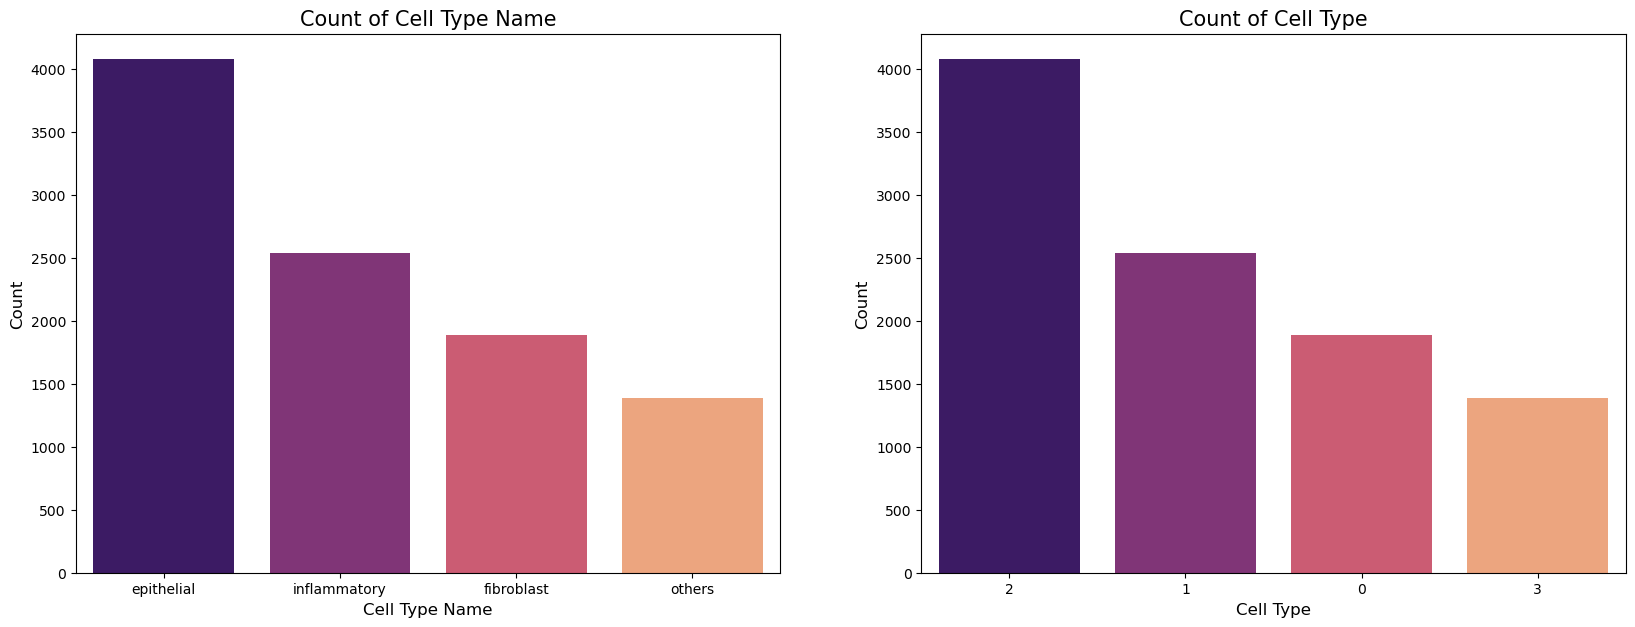

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7)) #create a figure with 2 subplots

sns.countplot(x='cellTypeName', data=df, palette='magma', order=df['cellTypeName'].value_counts().index, ax=axs[0])
axs[0].set_title('Count of Cell Type Name', fontsize=15)
axs[0].set_xlabel('Cell Type Name', fontsize=12)
axs[0].set_ylabel('Count', fontsize=12)

sns.countplot(x='cellType', data=df, palette='magma', order=df['cellType'].value_counts().index, ax=axs[1])
axs[1].set_title('Count of Cell Type', fontsize=15)
axs[1].set_xlabel('Cell Type', fontsize=12)
axs[1].set_ylabel('Count', fontsize=12)

plt.show()

We can see that the most amount of cell types appears to be `epithelial` whereas `others` has the least count.    
Additionally, the two features `cellTypeName` and `cellType` seem to be representing the same data. Let's further investigate that.

In [8]:
df['cellTypeName-numeric'] = df['cellTypeName'].map({'fibroblast':0,'inflammatory':1,'others':3,'epithelial':2})
if df['cellTypeName-numeric'].equals(df['cellType']):
    print("cellTypeName and cellType represent the same data")
else:
    print("cellTypeName and cellType do not represent the same data")

cellTypeName and cellType represent the same data


As they represent the same data we will remove `cellTypeName`. Since we no longer need `cellTypeName-numeric` we will drop that as well.

In [9]:
df = df.drop(['cellTypeName', 'cellTypeName-numeric'],axis=1)
df.head()

,ImageName,cellType,isCancerous
0,22405.png,0,0
1,22406.png,0,0
2,22407.png,0,0
3,22408.png,0,0
4,22409.png,0,0


___

## Loading Images <a class="anchor" id="loading_images"></a>

Now we will load the images in the dataframe.

In [10]:
df['ImgPath'] = '../Image_classification_data/patch_images/' + df['ImageName']
df.head()

,ImageName,cellType,isCancerous,ImgPath
0,22405.png,0,0,../Image_classification_data/patch_images/2240...
1,22406.png,0,0,../Image_classification_data/patch_images/2240...
2,22407.png,0,0,../Image_classification_data/patch_images/2240...
3,22408.png,0,0,../Image_classification_data/patch_images/2240...
4,22409.png,0,0,../Image_classification_data/patch_images/2240...


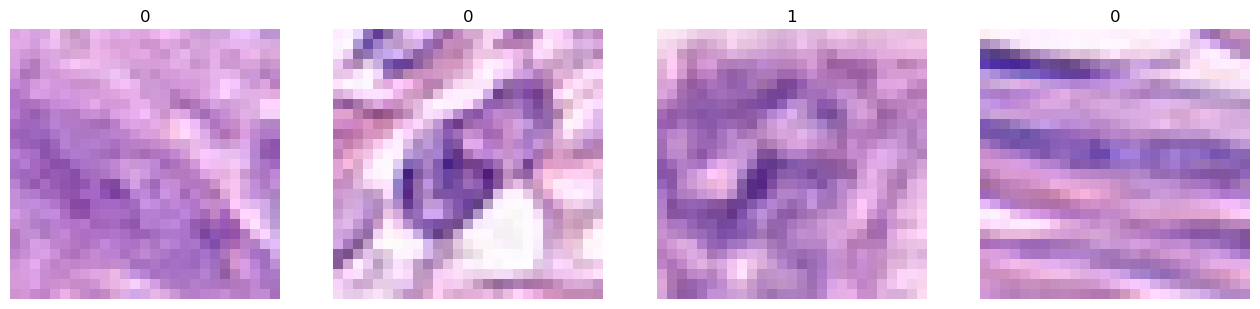

In [11]:
from PIL import Image
r_inx = np.random.choice(9896, 4)
rand_data = df.loc[r_inx,'ImgPath']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.title(df.iloc[r_inx[i]]['isCancerous'])
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

___

## Evaluation Framework <a class="anchor" id="evaluation"></a>

Setting up the base layers.

In [12]:
OUTPUT_CLASSES = 4
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM = 256

Splitting the data into training, testing and validation data sets. We will be using a 60/20/20 split.

In [13]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


Now we are going to create the data generator for each split.

In [14]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


## Model Development <a class="anchor" id="model"></a>

### Goals Determination <a class="anchor" id="goals"></a>

According to other research done on the “CRCHistoPhenotypes” dataset, with models trained to classify cell types, the average F1 score was 0.63. Therefore, we can set this as our target performance value. 

### Evaluation Metric <a class="anchor" id="metric"></a>

In the EDA, we observed that the 4 cell types had different distributions in the data. Therefore, we decided to use F1 Score as our performance metric. The F1 score is a harmonic mean of `precision` and `recall`, where `precision` is the number of true positives divided by the sum of true positives and false positives, and `recall` is the number of true positives divided by the sum of true positives and false negatives. The F1 score takes into account both precision and recall, which makes it a useful metric when the dataset is imbalanced.

We predefined a class that calculates the precision and recall then calculates the F1 score.

In [15]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1_score = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        return f1_score

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

### Setting Up the Experiment <a class="anchor" id="setting_up"></a>

We're going to define a function to plot our findings.

In [16]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r-')
    plt.plot(val_loss, 'b-')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r-')
    plt.plot(val_metric, 'b-')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

### Baseline Model <a class="anchor" id="baseline"></a>

For the baseline model, we are going to use a Convolutional Neural Network (CNN). A CNN is a good model to use for classification of cell types because CNNs are specifically designed to work with image data, making them a natural choice for this type of problem. A CNN can also automatically earn the features that are most relevant to the problem during the training process. Cell images often have important spatial relationships between the cells, such as the location of the nucleus within the cell. CNNs can also capture these spatial relationships, which can be important for accurate cell type classification.

In [17]:
#code adapted from week 8 labs given.

model1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

Epoch 1/10
186/186 [==============================] - 31s 161ms/step - loss: 0.4904 - f1_score: 0.2312 - val_loss: 0.3913 - val_f1_score: 0.4394
Epoch 2/10
186/186 [==============================] - 31s 166ms/step - loss: 0.3679 - f1_score: 0.5619 - val_loss: 0.3382 - val_f1_score: 0.5513
Epoch 3/10
186/186 [==============================] - 27s 144ms/step - loss: 0.3256 - f1_score: 0.6388 - val_loss: 0.3373 - val_f1_score: 0.5880
Epoch 4/10
186/186 [==============================] - 26s 141ms/step - loss: 0.3185 - f1_score: 0.6552 - val_loss: 0.3039 - val_f1_score: 0.6581
Epoch 5/10
186/186 [==============================] - 27s 147ms/step - loss: 0.3032 - f1_score: 0.6818 - val_loss: 0.3083 - val_f1_score: 0.6841
Epoch 6/10
186/186 [==============================] - 29s 157ms/step - loss: 0.2960 - f1_score: 0.6885 - val_loss: 0.2840 - val_f1_score: 0.6941
Epoch 7/10
186/186 [==============================] - 29s 158ms/step - loss: 0.2741 - f1_score: 0.7151 - val_loss: 0.2702 - val_f1

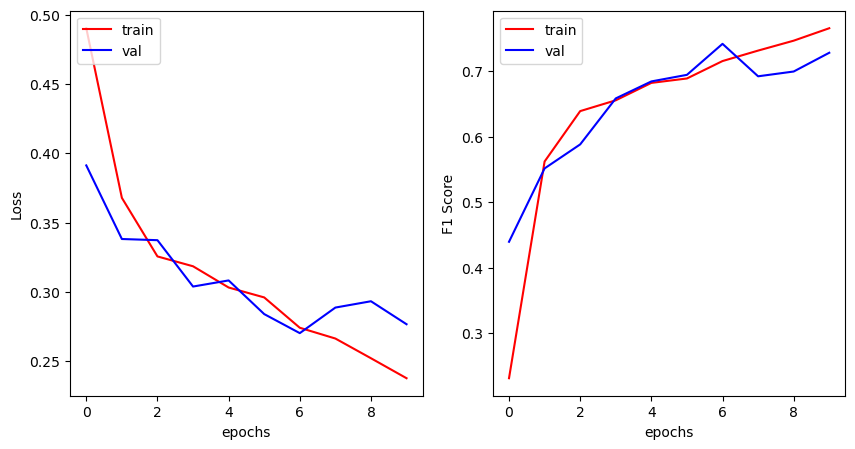

In [18]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history1 = model1.fit_generator(train_generator, 
                    validation_data=validation_generator, 
                    epochs=10, callbacks=[tensorboard_callback])

plot_learning_curve(history1.history['loss'], history1.history['val_loss'], 
                    history1.history['f1_score'], history1.history['val_f1_score'], 
                    metric_name='F1 Score')

This is our baseline model. We can see that the model was doing well until the end where it then started to over-fit the data. We can see the F1 scores and the loss differing towards the end. Ee will need to apply regularisation to minimize the effect of overfitting.

### Regularization <a class="anchor" id="regularisation"></a>

To minimise the effect of over-fitting, we are using L2 regularisation. L2 regularisation adds a penalty term to the loss function of the neural network which can prevent over-fitting and control model complexity. We are using an initial lambda value of 0.001.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

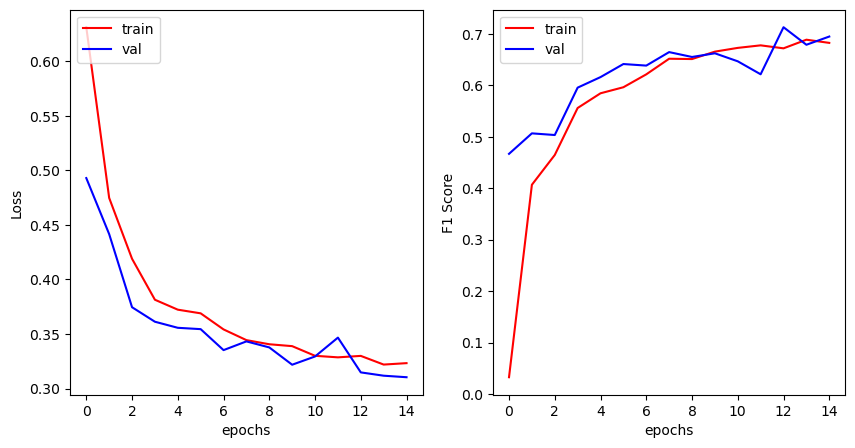

In [20]:
reg_lambda = 0.001

model_reg = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model_reg.summary()

model_reg.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history_reg = model_reg.fit_generator(train_generator, 
                    validation_data=validation_generator, 
                    epochs=15, callbacks=[tensorboard_callback])

plot_learning_curve(history_reg.history['loss'], history_reg.history['val_loss'], 
                    history_reg.history['f1_score'], history_reg.history['val_f1_score'], 
                    metric_name='F1 Score')

From the above graphs, we can see that the model is no longer over-fitting because both training data and validation data have the almost same F1 score and loss.
Let us use a different lambda value to see if the model performs better and also does not over-fit.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                 

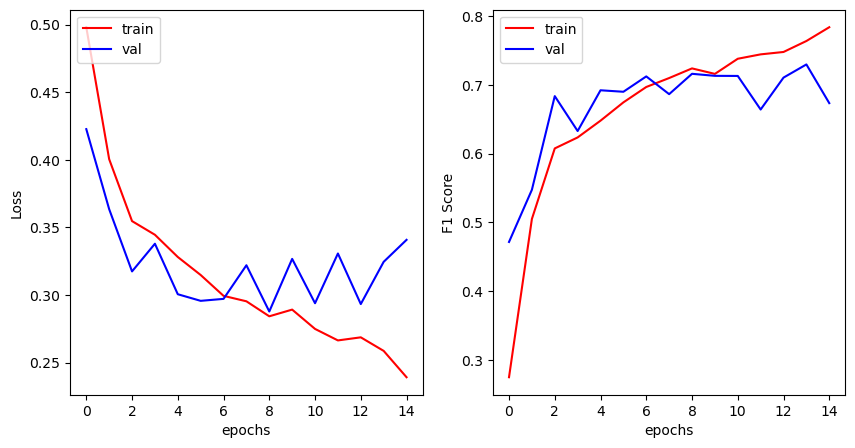

In [21]:
reg_lambda = 0.0001

model_reg2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model_reg2.summary()

model_reg2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history_reg2 = model_reg2.fit_generator(train_generator, 
                    validation_data=validation_generator, 
                    epochs=15, callbacks=[tensorboard_callback])

plot_learning_curve(history_reg2.history['loss'], history_reg2.history['val_loss'], 
                    history_reg2.history['f1_score'], history_reg2.history['val_f1_score'], 
                    metric_name='F1 Score')

We can see here that the F1 score for the training data improved but it didn't improve for the validation data which means that this model is over-fitting. So far the best lambda value we have is 0.001.
Let us try another lambda value and see if it fixes the over-fitting problem from this model.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                 

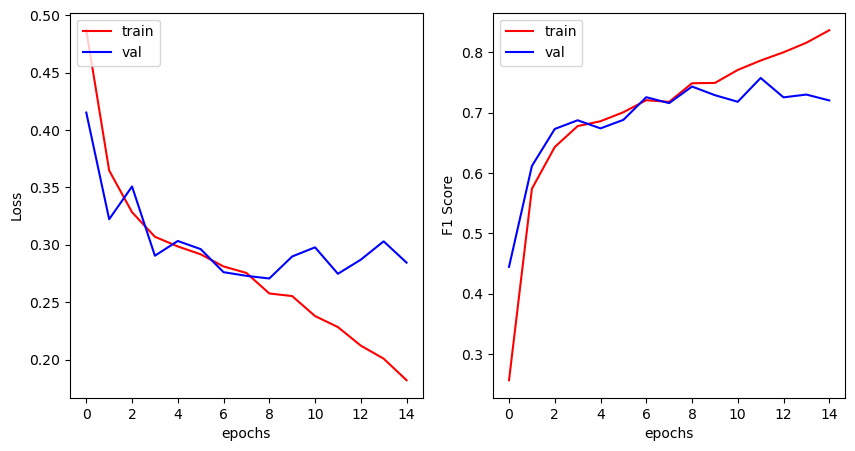

In [22]:
reg_lambda = 0.00001

model_reg3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model_reg3.summary()

model_reg3.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history_reg3 = model_reg3.fit_generator(train_generator, 
                    validation_data=validation_generator, 
                    epochs=15, callbacks=[tensorboard_callback])

plot_learning_curve(history_reg3.history['loss'], history_reg3.history['val_loss'], 
                    history_reg3.history['f1_score'], history_reg3.history['val_f1_score'], 
                    metric_name='F1 Score')

We can observe that this model is still over-fitting because the F1 scores for training and validation data are not improving together. Neither is the loss decreasing the same. This means that the one with the lambda value of 0.001 works the best.

### Data Augmentation <a class="anchor" id="augmentation"></a>

Data augmentation can be a useful technique to increase the size and diversity of your training data, which can help to improve the performance of the model. We are going to use 3 parameteres to increase the size and diversity of the training data: rotation, width shift and height shift. More specifically we are randomly rotating the image by a value between -15 and 15 degrees, shifting the image horizontally by a maximum of 20% of the image width and shifting the image horizontally by a maximum of 20% of the image width. This can help the model to generalize to new, shifted images.

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 28, 28, 1)         0         
                                                                 
 conv2d_30 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 11, 11, 32)        0         
                                                      

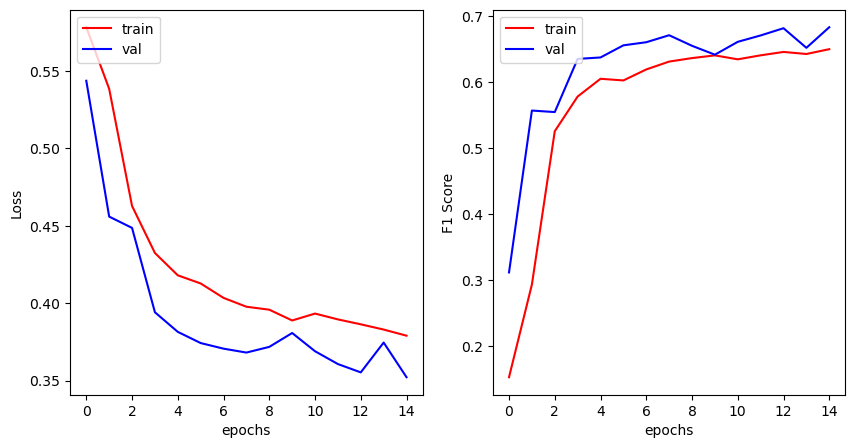

In [24]:
reg_lambda = 0.001

model_aug = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_aug.summary()

model_aug.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history_aug = model_aug.fit_generator(train_generator, 
                    validation_data=validation_generator, 
                    epochs=15, callbacks=[tensorboard_callback])

plot_learning_curve(history_aug.history['loss'], history_aug.history['val_loss'], 
                    history_aug.history['f1_score'], history_aug.history['val_f1_score'], 
                    metric_name='F1 Score')

From the plots above we can observe that the validation data did better than the training data in terms of the F1 Score and the Loss. Now let us do Hyper-Parameter Tuning to fine tune this by increasing the number of epochs.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_33 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 activation_4 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 activation_5 (Activation)   (None, 11, 11, 32)        0         
                                                      

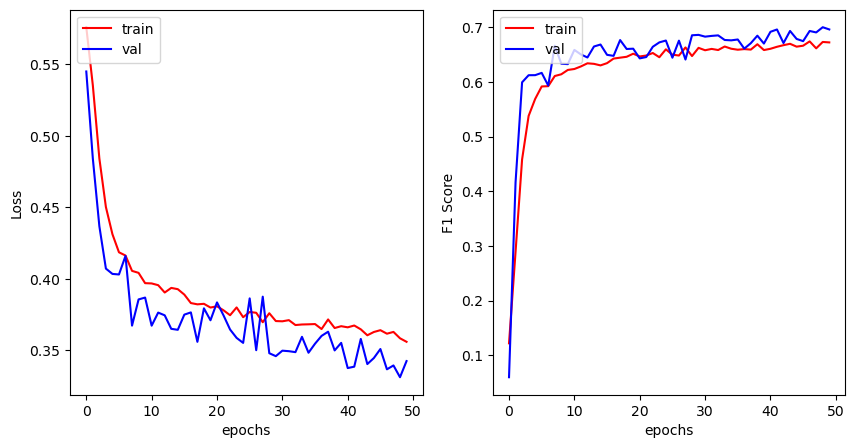

In [25]:
reg_lambda = 0.001

model_aug2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_aug2.summary()

model_aug2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history_aug2 = model_aug2.fit_generator(train_generator, 
                    validation_data=validation_generator, 
                    epochs=50, callbacks=[tensorboard_callback])

plot_learning_curve(history_aug2.history['loss'], history_aug2.history['val_loss'], 
                    history_aug2.history['f1_score'], history_aug2.history['val_f1_score'], 
                    metric_name='F1 Score')

We can see from the plots that this model performed better than the previous model. The F1 scores and Loss for the training and validation data sets were matching throughout. Now let us see how the model behaves if we increase the number of epochs even more.

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 activation_8 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 activation_9 (Activation)   (None, 11, 11, 32)        0         
                                                      

Epoch 41/150
186/186 [==============================] - 6s 31ms/step - loss: 0.3728 - f1_score: 0.6487 - val_loss: 0.3479 - val_f1_score: 0.6802
Epoch 42/150
186/186 [==============================] - 6s 33ms/step - loss: 0.3763 - f1_score: 0.6497 - val_loss: 0.3527 - val_f1_score: 0.6759
Epoch 43/150
186/186 [==============================] - 6s 30ms/step - loss: 0.3725 - f1_score: 0.6528 - val_loss: 0.3519 - val_f1_score: 0.6746
Epoch 44/150
186/186 [==============================] - 6s 31ms/step - loss: 0.3746 - f1_score: 0.6473 - val_loss: 0.3561 - val_f1_score: 0.6630
Epoch 45/150
186/186 [==============================] - 6s 32ms/step - loss: 0.3747 - f1_score: 0.6438 - val_loss: 0.3569 - val_f1_score: 0.6707
Epoch 46/150
186/186 [==============================] - 6s 32ms/step - loss: 0.3730 - f1_score: 0.6519 - val_loss: 0.3465 - val_f1_score: 0.6803
Epoch 47/150
186/186 [==============================] - 6s 34ms/step - loss: 0.3801 - f1_score: 0.6447 - val_loss: 0.3447 - val_f1

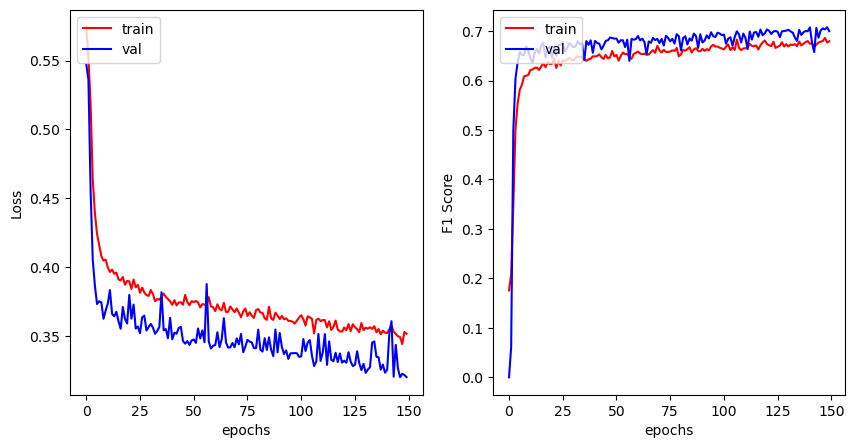

In [26]:
reg_lambda = 0.001

model_aug3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_aug3.summary()

model_aug3.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history_aug3 = model_aug3.fit_generator(train_generator, 
                    validation_data=validation_generator, 
                    epochs=150, callbacks=[tensorboard_callback])

plot_learning_curve(history_aug3.history['loss'], history_aug3.history['val_loss'], 
                    history_aug3.history['f1_score'], history_aug3.history['val_f1_score'], 
                    metric_name='F1 Score')

We can see that while the model performed well, there was some over-fitting. We can fix this by changing lambda value to 0.0001.

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_39 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 activation_12 (Activation)  (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 activation_13 (Activation)  (None, 11, 11, 32)        0         
                                                      

Epoch 41/150
186/186 [==============================] - 6s 31ms/step - loss: 0.3450 - f1_score: 0.6773 - val_loss: 0.3288 - val_f1_score: 0.7039
Epoch 42/150
186/186 [==============================] - 6s 32ms/step - loss: 0.3386 - f1_score: 0.6892 - val_loss: 0.3174 - val_f1_score: 0.7132
Epoch 43/150
186/186 [==============================] - 6s 30ms/step - loss: 0.3400 - f1_score: 0.6915 - val_loss: 0.3166 - val_f1_score: 0.7111
Epoch 44/150
186/186 [==============================] - 6s 31ms/step - loss: 0.3399 - f1_score: 0.6918 - val_loss: 0.3246 - val_f1_score: 0.7074
Epoch 45/150
186/186 [==============================] - 7s 38ms/step - loss: 0.3368 - f1_score: 0.6854 - val_loss: 0.3229 - val_f1_score: 0.7067
Epoch 46/150
186/186 [==============================] - 7s 36ms/step - loss: 0.3358 - f1_score: 0.6893 - val_loss: 0.3284 - val_f1_score: 0.7041
Epoch 47/150
186/186 [==============================] - 7s 39ms/step - loss: 0.3434 - f1_score: 0.6850 - val_loss: 0.3182 - val_f1

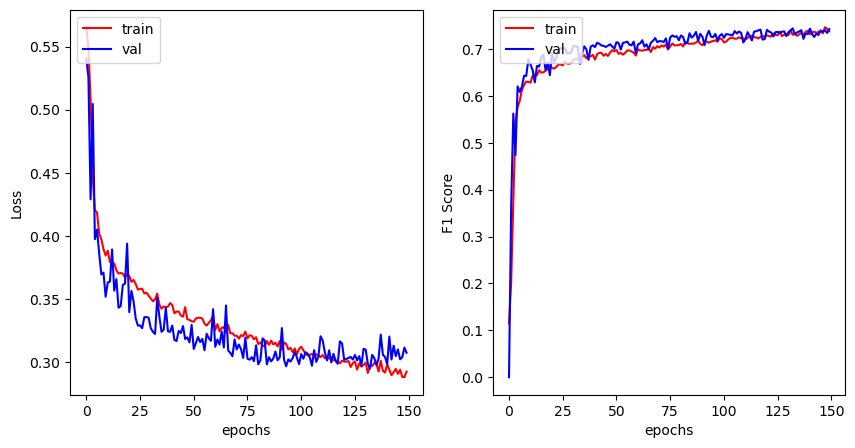

In [27]:
reg_lambda = 0.0001

model_aug4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_aug4.summary()

model_aug4.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history_aug4 = model_aug4.fit_generator(train_generator, 
                    validation_data=validation_generator, 
                    epochs=150, callbacks=[tensorboard_callback])

plot_learning_curve(history_aug4.history['loss'], history_aug4.history['val_loss'], 
                    history_aug4.history['f1_score'], history_aug4.history['val_f1_score'], 
                    metric_name='F1 Score')

After minimising the over-fitting, this model has the best performance so far. The F1 score for the training and validation data sets almost match and the loss is also not too bad for both the datasets. 

Since, we have minimum over-fitting and the F1 score and loss are the best we have seen so far, we will use this model as our final model.

## Testing the final model <a class="anchor" id="testing"></a>

Now that we have gotten our final model, let us test that model on our unseen (test) data. 

In [28]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


In [29]:
model_aug4.evaluate(test_generator)

62/62 [==============================] - 1s 10ms/step - loss: 0.3344 - f1_score: 0.7068


[0.3344487249851227, 0.7067549228668213]

We can see that the model performed well with a F1 score os 0.70 and a loss of 0.33.

___

## Semi - Supervised Learning <a class="anchor" id="semi_supervised"></a>

Semi-supervised learning is a technique that involves using an unlabelled dataset to improve a neural network developed on a labelled dataset. The technique we are doing is generating pseudo labels for the unlabelled dataset using the model we developed. Then we combine the two datasets to create a new dataset which we will then train the model further on.

In [30]:
#getting the unlabelled dataset
data_path2 = os.path.abspath('../Image_classification_data')

unlabeled_data = pd.read_csv(os.path.join(data_path2, 'data_labels_extraData.csv'), delimiter=',')

unlabeled_data['ImgPath'] = '../Image_classification_data/patch_images/' + unlabeled_data['ImageName']

#getting the list of image names in the patch_images directory
image_filenames = os.listdir('../Image_classification_data/patch_images')

#filtering out filenames that are not in the unlabeled_data dataframe
valid_filenames = [filename for filename in image_filenames if filename in unlabeled_data['ImageName'].tolist()]

#creating a DataFrame with the valid filenames and their corresponding paths
valid_data = pd.DataFrame({'ImageName': valid_filenames, 'ImgPath': ['../Image_classification_data/patch_images/' + f for f in valid_filenames]})

valid_data.head()

,ImageName,ImgPath
0,17843.png,../Image_classification_data/patch_images/1784...
1,21329.png,../Image_classification_data/patch_images/2132...
2,14392.png,../Image_classification_data/patch_images/1439...
3,15932.png,../Image_classification_data/patch_images/1593...
4,1804.png,../Image_classification_data/patch_images/1804...


In [31]:
#creating a data generation
image_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)

#creating a TensorFlow dataset from the valid data
valid_image_ds = image_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='ImgPath',
    y_col=None,
    target_size=(28, 28),
    class_mode=None,
    shuffle=False,
    batch_size=batch_size
)

#making predictions on the data using the trained model
pred_probs = model_aug4.predict(valid_image_ds, batch_size=batch_size)

#converting the predicted probabilities to pseudo-labels
pseudo_labels = np.argmax(pred_probs, axis=1)

#adding the pseudo-labels to the valid data
valid_data['pseudo_label'] = pd.Series(pseudo_labels, index=valid_data.index)

#merging the valid data with the unlabeled_data dataframe
unlabeled_data = pd.merge(unlabeled_data, valid_data, on='ImageName')
unlabeled_data.head()

Found 10384 validated image filenames.
325/325 [==============================] - 6s 18ms/step


,InstanceID,patientID,ImageName,isCancerous,ImgPath_x,ImgPath_y,pseudo_label
0,12681,61,12681.png,0,../Image_classification_data/patch_images/1268...,../Image_classification_data/patch_images/1268...,0
1,12682,61,12682.png,0,../Image_classification_data/patch_images/1268...,../Image_classification_data/patch_images/1268...,0
2,12683,61,12683.png,0,../Image_classification_data/patch_images/1268...,../Image_classification_data/patch_images/1268...,1
3,12684,61,12684.png,0,../Image_classification_data/patch_images/1268...,../Image_classification_data/patch_images/1268...,0
4,12685,61,12685.png,0,../Image_classification_data/patch_images/1268...,../Image_classification_data/patch_images/1268...,0


Now that we have pseudo labels for our unlabelled dataset, we are going to check the number of unique values in the `pseudo_label` column to ensure that the labels generated were of 4 classes, and we are also going to check what those unique values are.

In [32]:
unlabeled_data['pseudo_label'].nunique()

4

In [33]:
unlabeled_data['pseudo_label'].unique()

array([0, 1, 3, 2])

As we can see, the labels predicted by the model are of 4 classes and in the range of what they should be.  
Now we are going to combine this data with the labelled data we have, to create a new dataframe for new models to train on.

In [34]:
df2 = pd.concat([df, unlabeled_data.assign(cellType=pseudo_labels, ImgPath=unlabeled_data['ImgPath_x'])], axis=0)
df2.head()

,ImageName,cellType,isCancerous,ImgPath,InstanceID,patientID,ImgPath_x,ImgPath_y,pseudo_label
0,22405.png,0,0,../Image_classification_data/patch_images/2240...,NaN,NaN,NaN,NaN,NaN
1,22406.png,0,0,../Image_classification_data/patch_images/2240...,NaN,NaN,NaN,NaN,NaN
2,22407.png,0,0,../Image_classification_data/patch_images/2240...,NaN,NaN,NaN,NaN,NaN
3,22408.png,0,0,../Image_classification_data/patch_images/2240...,NaN,NaN,NaN,NaN,NaN
4,22409.png,0,0,../Image_classification_data/patch_images/2240...,NaN,NaN,NaN,NaN,NaN


We can see in this above dataframe that there are a lot of features that we do not need and/or are duplicate data which if not removed can lead to overfitting of the model. Therefore, we are going to remove these features and only keep the ones we will require.

In [35]:
df2 = df2.drop(['InstanceID','patientID', 'ImgPath_x', 'ImgPath_y', 'pseudo_label'], axis=1)
df2.head()

,ImageName,cellType,isCancerous,ImgPath
0,22405.png,0,0,../Image_classification_data/patch_images/2240...
1,22406.png,0,0,../Image_classification_data/patch_images/2240...
2,22407.png,0,0,../Image_classification_data/patch_images/2240...
3,22408.png,0,0,../Image_classification_data/patch_images/2240...
4,22409.png,0,0,../Image_classification_data/patch_images/2240...


Now let us find the shape of this new dataframe.

In [36]:
df2.shape

(20280, 4)

We can see that this dataframe now consists of 20280 rows and 4 features.

Now we are going to resplit this data in the ratio of 60/20/20 for our new models.

In [37]:
train_data2, test_data2 = train_test_split(df2, test_size=0.2, random_state=42)
train_data2, val_data2 = train_test_split(train_data2, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


We will now create data generation for each split.

In [38]:
train_data2['cellType'] = train_data2['cellType'].astype('str')
val_data2['cellType'] = val_data2['cellType'].astype('str')

train_datagen2 = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)
val_datagen2 = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator2 = train_datagen2.flow_from_dataframe(
        dataframe=train_data2,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator2 = val_datagen2.flow_from_dataframe(
        dataframe=val_data2,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 4 classes.
Found 4056 validated image filenames belonging to 4 classes.


Now let us fit a new model on these new data generations.

Epoch 1/150
381/381 [==============================] - 11s 29ms/step - loss: 0.4830 - f1_score: 0.4785 - val_loss: 0.4608 - val_f1_score: 0.4974
Epoch 2/150
381/381 [==============================] - 9s 24ms/step - loss: 0.4639 - f1_score: 0.5093 - val_loss: 0.4591 - val_f1_score: 0.5321
Epoch 3/150
381/381 [==============================] - 9s 24ms/step - loss: 0.4615 - f1_score: 0.5066 - val_loss: 0.4600 - val_f1_score: 0.5190
Epoch 4/150
381/381 [==============================] - 9s 24ms/step - loss: 0.4588 - f1_score: 0.5195 - val_loss: 0.4520 - val_f1_score: 0.5200
Epoch 5/150
381/381 [==============================] - 9s 24ms/step - loss: 0.4563 - f1_score: 0.5182 - val_loss: 0.4674 - val_f1_score: 0.5165
Epoch 6/150
381/381 [==============================] - 11s 28ms/step - loss: 0.4564 - f1_score: 0.5177 - val_loss: 0.4542 - val_f1_score: 0.5260
Epoch 7/150
381/381 [==============================] - 8s 21ms/step - loss: 0.4530 - f1_score: 0.5231 - val_loss: 0.4527 - val_f1_scor

381/381 [==============================] - 8s 22ms/step - loss: 0.4289 - f1_score: 0.5589 - val_loss: 0.4556 - val_f1_score: 0.5262
Epoch 114/150
381/381 [==============================] - 8s 22ms/step - loss: 0.4335 - f1_score: 0.5516 - val_loss: 0.4556 - val_f1_score: 0.5349
Epoch 115/150
381/381 [==============================] - 9s 23ms/step - loss: 0.4309 - f1_score: 0.5572 - val_loss: 0.4618 - val_f1_score: 0.5351
Epoch 116/150
381/381 [==============================] - 8s 20ms/step - loss: 0.4274 - f1_score: 0.5634 - val_loss: 0.4536 - val_f1_score: 0.5281
Epoch 117/150
381/381 [==============================] - 9s 23ms/step - loss: 0.4285 - f1_score: 0.5569 - val_loss: 0.4546 - val_f1_score: 0.5239
Epoch 118/150
381/381 [==============================] - 8s 21ms/step - loss: 0.4285 - f1_score: 0.5645 - val_loss: 0.4581 - val_f1_score: 0.5171
Epoch 119/150
381/381 [==============================] - 9s 23ms/step - loss: 0.4308 - f1_score: 0.5579 - val_loss: 0.4502 - val_f1_score:

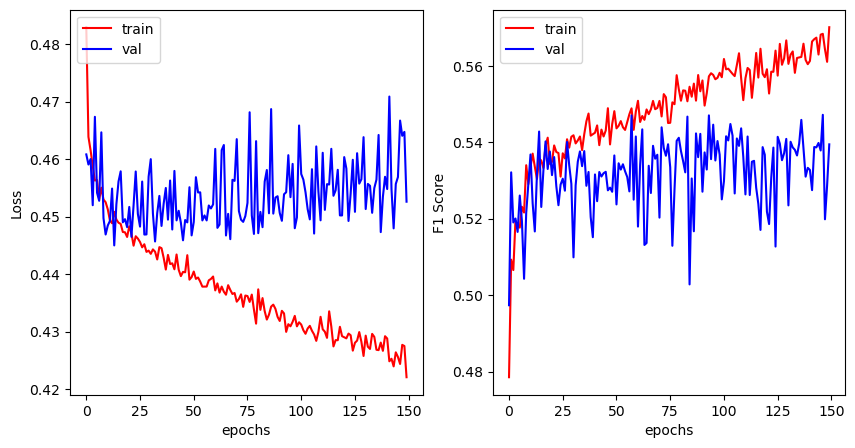

In [39]:
model_aug4.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history_aug_new = model_aug4.fit_generator(train_generator2, 
                    validation_data=validation_generator2, 
                    epochs=150, callbacks=[tensorboard_callback])

plot_learning_curve(history_aug_new.history['loss'], history_aug_new.history['val_loss'], 
                    history_aug_new.history['f1_score'], history_aug_new.history['val_f1_score'], 
                    metric_name='F1 Score')

We can observe from the above plots that the model is over-fitting. We can see that as the epochs increase the F1 score and loss for the training data increase and decrease respectively, however the F1 score and loss remain almost the same throughout. 

To minimise the over-fitting, we are going to change the lambda value to 0.00001 and redevelop the model.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_42 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 activation_16 (Activation)  (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 activation_17 (Activation)  (None, 11, 11, 32)        0         
                                                      

Epoch 41/150
381/381 [==============================] - 10s 25ms/step - loss: 0.4539 - f1_score: 0.5233 - val_loss: 0.4552 - val_f1_score: 0.5166
Epoch 42/150
381/381 [==============================] - 9s 22ms/step - loss: 0.4554 - f1_score: 0.5217 - val_loss: 0.4546 - val_f1_score: 0.5086
Epoch 43/150
381/381 [==============================] - 9s 23ms/step - loss: 0.4549 - f1_score: 0.5233 - val_loss: 0.4568 - val_f1_score: 0.5162
Epoch 44/150
381/381 [==============================] - 8s 21ms/step - loss: 0.4560 - f1_score: 0.5205 - val_loss: 0.4658 - val_f1_score: 0.4906
Epoch 45/150
381/381 [==============================] - 8s 21ms/step - loss: 0.4561 - f1_score: 0.5189 - val_loss: 0.4562 - val_f1_score: 0.5082
Epoch 46/150
381/381 [==============================] - 8s 22ms/step - loss: 0.4564 - f1_score: 0.5190 - val_loss: 0.4548 - val_f1_score: 0.5179
Epoch 47/150
381/381 [==============================] - 11s 28ms/step - loss: 0.4548 - f1_score: 0.5223 - val_loss: 0.4512 - val_

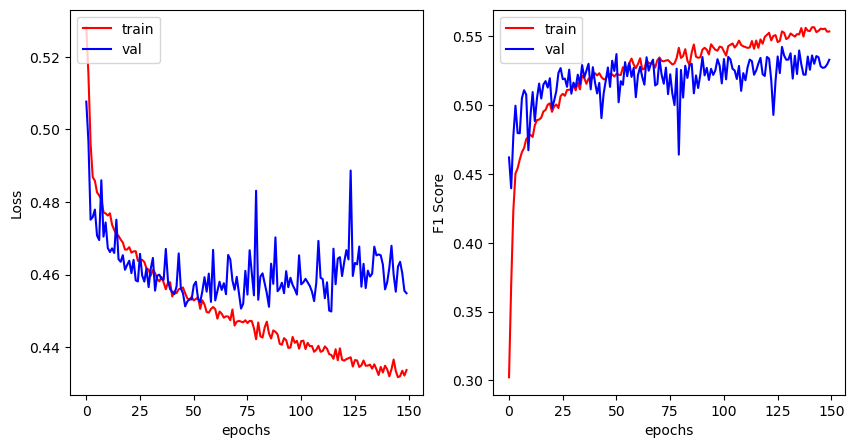

In [40]:
reg_lambda = 0.00001

model_aug5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_aug5.summary()

model_aug5.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history_aug5 = model_aug5.fit_generator(train_generator2, 
                    validation_data=validation_generator2, 
                    epochs=150, callbacks=[tensorboard_callback])

plot_learning_curve(history_aug5.history['loss'], history_aug5.history['val_loss'], 
                    history_aug5.history['f1_score'], history_aug5.history['val_f1_score'], 
                    metric_name='F1 Score')

When we look at the plots, the model is not over-fitting too much since there is not much of a difference between the F1 scores. Even with the loss, the difference is about 0.04. The reason we're not using building another model with a different lambda value is because decreasing the lambda value too much can lead to the regularization effect becoming weaker which is the opposite of what we want.

Since this is the best model we have obtained for the semi-supervised learning so far, we will continue with this model.

### Testing Semi-Supervised Model <a class="anchor" id="testing2"></a>

Now that we have a final model for the semi-supervised learning, we can test that model on our unseen data.

In [42]:
test_data2['cellType'] = test_data2['cellType'].astype('str')

test_datagen2 = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

test_generator2 = test_datagen2.flow_from_dataframe(
        dataframe=test_data2,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 4 classes.


In [43]:
model_aug5.evaluate(test_generator2)

127/127 [==============================] - 1s 10ms/step - loss: 0.4470 - f1_score: 0.5530


[0.44702714681625366, 0.5529841184616089]

We can observe that we are getting a loss of 0.44 and a F1 score of 0.5530 for the unseen data.

___